# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim to achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about 6.8% from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

## Load Data

In [2]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from datetime import datetime, timedelta
from keras.models import load_model, Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import TensorBoard


Autosaving every 5 seconds


In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'scripts')

from utilities_activity7 import *

np.random.seed(0)

In [6]:
#  Load datasets
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

In [7]:
#  Convert `date` column to datetime type
test['date'] = test['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [8]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)
test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [9]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

## Reference Model

In [11]:
#  TASK:
#  Load data for `v0` of our model.
#  Call this `model_v0`.
model_v0 = load_model('bitcoin_lstm_v0.h5')


In [12]:
%%time

#  TASK:
#  Train the reference model `model_v0`.
#
train_model(model=model_v0, X=X_train, Y=Y_train ,epochs=100, version=0, run_number=0)


Epoch 1/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 9.3836e-04
Epoch 12/100
1/1 [==============================] - 0s 1ms/step 

1/1 [==============================] - 0s 5ms/step - loss: 4.6300e-06
Epoch 97/100
1/1 [==============================] - 0s 3ms/step - loss: 4.9275e-06
Epoch 98/100
1/1 [==============================] - 0s 2ms/step - loss: 5.0855e-06
Epoch 99/100
1/1 [==============================] - 0s 2ms/step - loss: 5.2641e-06
Epoch 100/100
1/1 [==============================] - 0s 3ms/step - loss: 5.2190e-06
CPU times: user 7.95 s, sys: 1.13 s, total: 9.08 s
Wall time: 8.13 s


## Adding Layers and Nodes

In [13]:
#  Initialize variables
period_length = 7
number_of_periods = 76
batch_size = 1

In [14]:
#  Model 1: two LSTM layers
model_v1 = Sequential()

model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))   # note return_sequences is now true

#  TASK:
#  Add new LSTM layer to this network here.
#


model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [15]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 13/100
1/1 [==============================] - 0s 3ms/st

1/1 [==============================] - 0s 3ms/step - loss: 2.4971e-05
CPU times: user 3.95 s, sys: 284 ms, total: 4.23 s
Wall time: 3.63 s


## Epochs

In [16]:
# Model 2: two LSTM layers, trained for 300 epochs
model_v2 = Sequential()

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [17]:
%%time

#  TASK:
#  Change the number of epochs below
#  to 300 and evaluate the results on TensorBoard.
#
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=100, version=2, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 9.4163e-04
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 7.8851e-04
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 6.6417e-04
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 5.6214e-04
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 4.7756e-04
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 4.0680e-04
Epoch 13/100
1/1 [===================

1/1 [==============================] - 0s 4ms/step - loss: 1.1060e-05
CPU times: user 6.53 s, sys: 485 ms, total: 7.01 s
Wall time: 5.27 s


## Activation Functions

In [18]:
# Model 3: two LSTM layers, trained for 300 epochs,
#          tanh activation function
model_v3 = Sequential()

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))

#  TASK:
#  Change the activation function
#  from "linear" to "tanh".
#
model_v3.add(Activation("linear"))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [19]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 4/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 5/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 9.3227e-04
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 7.9564e-04
Epoch 8/300
1/1 [==============================] - 0s 4ms/step - loss: 6.8632e-04
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 5.9666e-04
Epoch 10/300
1/1 [==============================] - 0s 4ms/step - loss: 5.2148e-04
Epoch 11/300
1/1 [==============================] - 0s 1ms/step - loss: 4.5718e-04
Epoch 12/300
1/1 [==============================] - 0s 2ms/step - loss: 4.0122e-04
Epoch 13/300
1/1 [===============

1/1 [==============================] - 0s 2ms/step - loss: 1.4802e-05
Epoch 101/300
1/1 [==============================] - 0s 3ms/step - loss: 1.2284e-05
Epoch 102/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1340e-05
Epoch 103/300
1/1 [==============================] - 0s 2ms/step - loss: 1.0299e-05
Epoch 104/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1505e-05
Epoch 105/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3667e-05
Epoch 106/300
1/1 [==============================] - 0s 3ms/step - loss: 1.3214e-05
Epoch 107/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1050e-05
Epoch 108/300
1/1 [==============================] - 0s 2ms/step - loss: 7.4710e-06
Epoch 109/300
1/1 [==============================] - 0s 1ms/step - loss: 5.6805e-06
Epoch 110/300
1/1 [==============================] - 0s 2ms/step - loss: 4.6145e-06
Epoch 111/300
1/1 [==============================] - 0s 2ms/step - loss: 4.6045e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 1.1263e-05
Epoch 198/300
1/1 [==============================] - 0s 2ms/step - loss: 1.0190e-05
Epoch 199/300
1/1 [==============================] - 0s 2ms/step - loss: 7.0919e-06
Epoch 200/300
1/1 [==============================] - 0s 2ms/step - loss: 5.7476e-06
Epoch 201/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3469e-06
Epoch 202/300
1/1 [==============================] - 0s 2ms/step - loss: 4.1222e-06
Epoch 203/300
1/1 [==============================] - 0s 2ms/step - loss: 4.1526e-06
Epoch 204/300
1/1 [==============================] - 0s 3ms/step - loss: 5.3185e-06
Epoch 205/300
1/1 [==============================] - 0s 2ms/step - loss: 7.5182e-06
Epoch 206/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1467e-05
Epoch 207/300
1/1 [==============================] - 0s 2ms/step - loss: 1.4896e-05
Epoch 208/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3246e-05
Epoch 

1/1 [==============================] - 0s 1ms/step - loss: 1.1292e-05
Epoch 295/300
1/1 [==============================] - 0s 1ms/step - loss: 1.6532e-05
Epoch 296/300
1/1 [==============================] - 0s 2ms/step - loss: 1.4973e-05
Epoch 297/300
1/1 [==============================] - 0s 2ms/step - loss: 1.0047e-05
Epoch 298/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3794e-06
Epoch 299/300
1/1 [==============================] - 0s 2ms/step - loss: 3.3594e-06
Epoch 300/300
1/1 [==============================] - 0s 2ms/step - loss: 2.1977e-06
CPU times: user 13.6 s, sys: 1.31 s, total: 14.9 s
Wall time: 9.9 s


## Regularization Strategies

In [20]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#  TASK:
#  Implement a Dropout() here.
#


model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#  TASK:
#  Implement a Dropout() here too.
#


model_v4.add(Dense(units=period_length))
model_v4.add(Activation("tanh"))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [21]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, version=4, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 2/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/600
1/1 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4/600
1/1 [==============================] - 0s 1ms/step - loss: 7.5774e-04
Epoch 5/600
1/1 [==============================] - 0s 2ms/step - loss: 5.7474e-04
Epoch 6/600
1/1 [==============================] - 0s 2ms/step - loss: 4.3982e-04
Epoch 7/600
1/1 [==============================] - 0s 2ms/step - loss: 3.3785e-04
Epoch 8/600
1/1 [==============================] - 0s 2ms/step - loss: 2.5978e-04
Epoch 9/600
1/1 [==============================] - 0s 2ms/step - loss: 1.9962e-04
Epoch 10/600
1/1 [==============================] - 0s 3ms/step - loss: 1.5313e-04
Epoch 11/600
1/1 [==============================] - 0s 2ms/step - loss: 1.1718e-04
Epoch 12/600
1/1 [==============================] - 0s 2ms/step - loss: 8.9408e-05
Epoch 13/600
1/1 [=======

Epoch 100/600
1/1 [==============================] - 0s 2ms/step - loss: 4.1345e-06
Epoch 101/600
1/1 [==============================] - 0s 2ms/step - loss: 5.4354e-06
Epoch 102/600
1/1 [==============================] - 0s 2ms/step - loss: 7.0015e-06
Epoch 103/600
1/1 [==============================] - 0s 2ms/step - loss: 8.6567e-06
Epoch 104/600
1/1 [==============================] - 0s 2ms/step - loss: 8.4138e-06
Epoch 105/600
1/1 [==============================] - 0s 2ms/step - loss: 7.2703e-06
Epoch 106/600
1/1 [==============================] - 0s 1ms/step - loss: 5.3982e-06
Epoch 107/600
1/1 [==============================] - 0s 3ms/step - loss: 4.2509e-06
Epoch 108/600
1/1 [==============================] - ETA: 0s - loss: 3.4394e-0 - 0s 2ms/step - loss: 3.4394e-06
Epoch 109/600
1/1 [==============================] - 0s 2ms/step - loss: 3.3655e-06
Epoch 110/600
1/1 [==============================] - 0s 2ms/step - loss: 3.7064e-06
Epoch 111/600
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 3.2826e-06
Epoch 197/600
1/1 [==============================] - 0s 1ms/step - loss: 4.1302e-06
Epoch 198/600
1/1 [==============================] - 0s 1ms/step - loss: 4.9545e-06
Epoch 199/600
1/1 [==============================] - 0s 2ms/step - loss: 6.0448e-06
Epoch 200/600
1/1 [==============================] - 0s 1ms/step - loss: 5.9803e-06
Epoch 201/600
1/1 [==============================] - 0s 3ms/step - loss: 5.5068e-06
Epoch 202/600
1/1 [==============================] - 0s 2ms/step - loss: 4.2889e-06
Epoch 203/600
1/1 [==============================] - 0s 3ms/step - loss: 3.5410e-06
Epoch 204/600
1/1 [==============================] - 0s 2ms/step - loss: 2.8489e-06
Epoch 205/600
1/1 [==============================] - 0s 2ms/step - loss: 2.7269e-06
Epoch 206/600
1/1 [==============================] - 0s 2ms/step - loss: 2.8220e-06
Epoch 207/600
1/1 [==============================] - 0s 2ms/step - loss: 3.6969e-06
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 3.8723e-06
Epoch 294/600
1/1 [==============================] - 0s 4ms/step - loss: 3.5447e-06
Epoch 295/600
1/1 [==============================] - 0s 2ms/step - loss: 3.4449e-06
Epoch 296/600
1/1 [==============================] - 0s 2ms/step - loss: 3.0977e-06
Epoch 297/600
1/1 [==============================] - 0s 2ms/step - loss: 3.1973e-06
Epoch 298/600
1/1 [==============================] - 0s 2ms/step - loss: 3.5263e-06
Epoch 299/600
1/1 [==============================] - 0s 2ms/step - loss: 4.7037e-06
Epoch 300/600
1/1 [==============================] - 0s 2ms/step - loss: 5.5571e-06
Epoch 301/600
1/1 [==============================] - 0s 2ms/step - loss: 5.8593e-06
Epoch 302/600
1/1 [==============================] - 0s 2ms/step - loss: 4.7086e-06
Epoch 303/600
1/1 [==============================] - 0s 2ms/step - loss: 3.8786e-06
Epoch 304/600
1/1 [==============================] - 0s 2ms/step - loss: 3.0138e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 3.3533e-06
Epoch 391/600
1/1 [==============================] - 0s 2ms/step - loss: 3.9303e-06
Epoch 392/600
1/1 [==============================] - 0s 2ms/step - loss: 4.5661e-06
Epoch 393/600
1/1 [==============================] - 0s 1ms/step - loss: 5.0944e-06
Epoch 394/600
1/1 [==============================] - 0s 2ms/step - loss: 4.2725e-06
Epoch 395/600
1/1 [==============================] - 0s 2ms/step - loss: 3.7986e-06
Epoch 396/600
1/1 [==============================] - 0s 2ms/step - loss: 3.4561e-06
Epoch 397/600
1/1 [==============================] - 0s 2ms/step - loss: 3.9732e-06
Epoch 398/600
1/1 [==============================] - 0s 1ms/step - loss: 4.3129e-06
Epoch 399/600
1/1 [==============================] - 0s 2ms/step - loss: 4.4885e-06
Epoch 400/600
1/1 [==============================] - 0s 1ms/step - loss: 3.7647e-06
Epoch 401/600
1/1 [==============================] - 0s 1ms/step - loss: 3.2776e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 2.9271e-06
Epoch 488/600
1/1 [==============================] - 0s 2ms/step - loss: 3.0682e-06
Epoch 489/600
1/1 [==============================] - 0s 2ms/step - loss: 3.3550e-06
Epoch 490/600
1/1 [==============================] - 0s 3ms/step - loss: 3.2656e-06
Epoch 491/600
1/1 [==============================] - 0s 2ms/step - loss: 3.2917e-06
Epoch 492/600
1/1 [==============================] - 0s 2ms/step - loss: 2.9653e-06
Epoch 493/600
1/1 [==============================] - 0s 2ms/step - loss: 3.1227e-06
Epoch 494/600
1/1 [==============================] - 0s 1ms/step - loss: 3.7502e-06
Epoch 495/600
1/1 [==============================] - 0s 2ms/step - loss: 5.1898e-06
Epoch 496/600
1/1 [==============================] - 0s 2ms/step - loss: 5.0337e-06
Epoch 497/600
1/1 [==============================] - 0s 5ms/step - loss: 4.3346e-06
Epoch 498/600
1/1 [==============================] - 0s 5ms/step - loss: 3.3571e-06
Epoch 

1/1 [==============================] - 0s 7ms/step - loss: 3.0210e-06
Epoch 585/600
1/1 [==============================] - 0s 2ms/step - loss: 3.2843e-06
Epoch 586/600
1/1 [==============================] - 0s 3ms/step - loss: 3.0554e-06
Epoch 587/600
1/1 [==============================] - 0s 2ms/step - loss: 2.8137e-06
Epoch 588/600
1/1 [==============================] - 0s 2ms/step - loss: 2.4011e-06
Epoch 589/600
1/1 [==============================] - 0s 1ms/step - loss: 2.3007e-06
Epoch 590/600
1/1 [==============================] - 0s 1ms/step - loss: 2.2485e-06
Epoch 591/600
1/1 [==============================] - 0s 2ms/step - loss: 2.5126e-06
Epoch 592/600
1/1 [==============================] - 0s 3ms/step - loss: 2.7180e-06
Epoch 593/600
1/1 [==============================] - 0s 2ms/step - loss: 3.1059e-06
Epoch 594/600
1/1 [==============================] - 0s 3ms/step - loss: 3.1833e-06
Epoch 595/600
1/1 [==============================] - 0s 4ms/step - loss: 3.2951e-06
Epoch 

## Evaluate Models

In [22]:
combined_set = np.concatenate((train_data, test_data), axis=1)

def evaluate_model(model, kind='series'):
    """Compute the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [23]:
def plot_weekly_mse(series, model_name, color):
    """Plot weekly MSE."""
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    ax.set_xticks(range(0, len(series)))
    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")

    return ax

In [24]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    """Plot weekly predictions and calculate RMSE and MAPE."""
    
    # Create dataframe to store predictions and associated dates
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days,
        'close_point_relative_normalization': predicted_days
    })
    
    # Convert `date` variable to datetime
    predicted['date'] = predicted['date'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d'))

    # Create iso_week column in `predicted` dataframe
    predicted['iso_week'] = predicted['date'].apply(
        lambda x: x.strftime('%Y-%U'))

    # Denormalize predictions
    predicted_close = predicted.groupby('iso_week').apply(
        lambda x: denormalize(test[:-3], x))

    # Plot denormalized predictions and observed values
    plot_two_series(test[:-3], predicted_close,
                    variable=variable,
                    title=f'{name}: Predictions per Week')
    
    # Calculate RMSE and MAPE
    print(f'RMSE: {rmse(test[:-3][variable], predicted_close[variable]):.2f}')
    print(f'MAPE: {mape(test[:-3][variable], predicted_close[variable]):.2f}%')

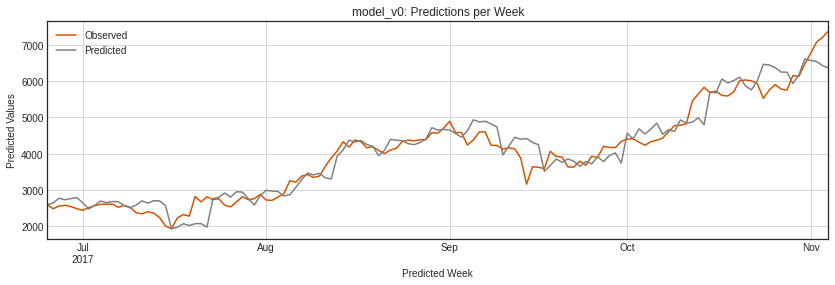

RMSE: 354.12
MAPE: 6.84%


IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:

#  Evaluate each model trained in this activity in sequence
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='series')
    plot_weekly_predictions(predicted_days,('model_v{0}'.format(i)))